In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Data preprocessing

In [125]:
df = pd.read_csv('./embeddings_combined.csv')

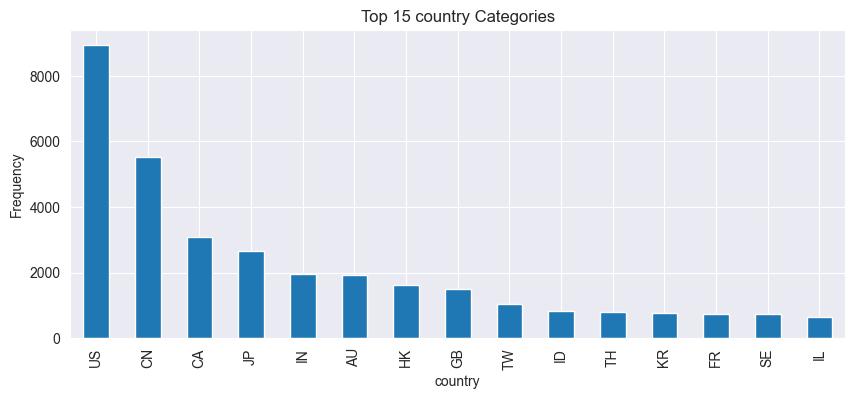

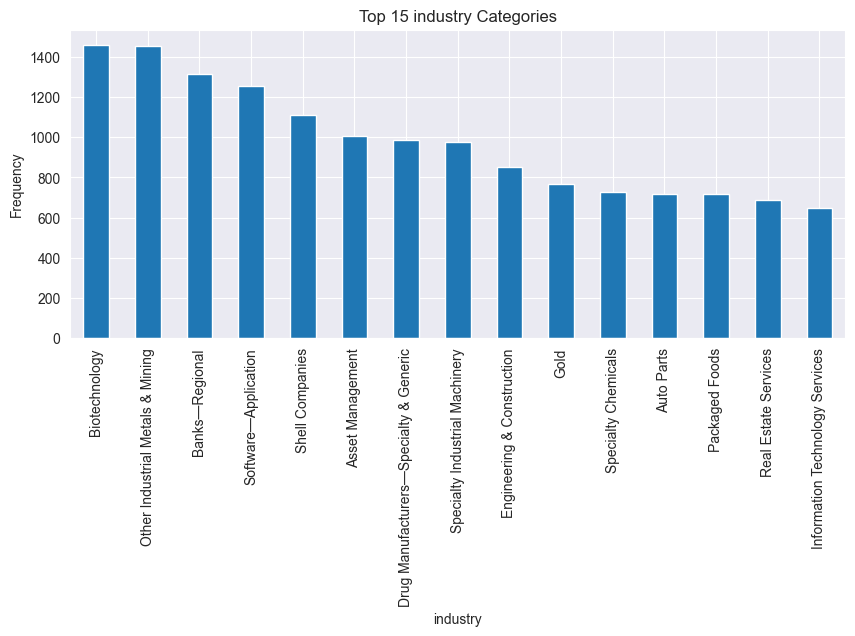

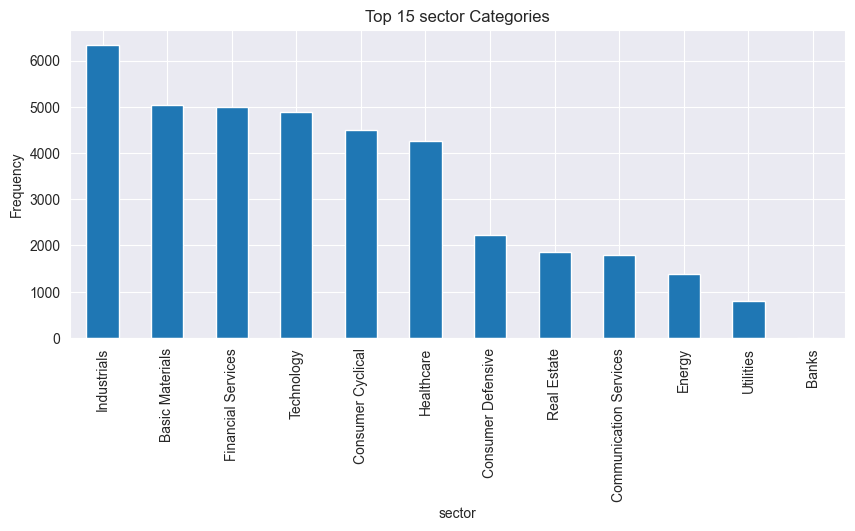

In [126]:
for column in ['country', 'industry', 'sector']:
    plt.figure(figsize=(10, 4))
    df[column].value_counts().head(15).plot(kind='bar')
    plt.title(f'Top 15 {column} Categories')
    plt.ylabel('Frequency')
    plt.show()

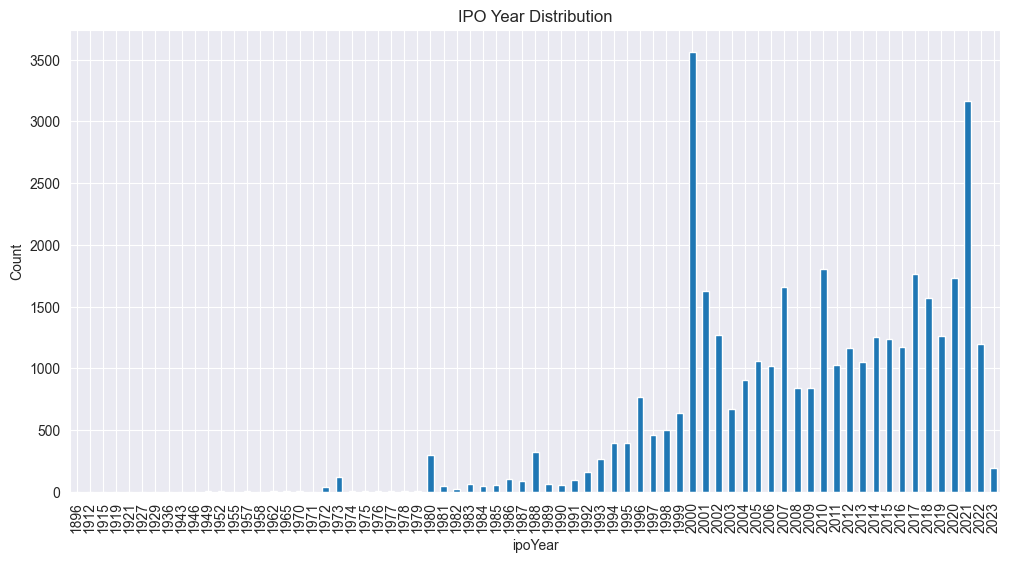

In [127]:
# 3. IPO Date Analysis
df['ipoDate'] = pd.to_datetime(df['ipoDate'])
df['ipoYear'] = df['ipoDate'].dt.year
df['ipoMonth'] = df['ipoDate'].dt.month
plt.figure(figsize=(12, 6))
df['ipoYear'].value_counts().sort_index().plot(kind='bar')
plt.title('IPO Year Distribution')
plt.ylabel('Count')
plt.show()

In [128]:
from sklearn.preprocessing import StandardScaler

embedding_cols = [str(i) for i in range(1024)]
scaler = StandardScaler()
df[embedding_cols] = scaler.fit_transform(df[embedding_cols].values)

In [129]:
# Dimensionality Reeduction using PCA
from sklearn.decomposition import PCA

PCA_reducer = PCA(n_components=512)
pca_embeddings = PCA_reducer.fit_transform(df[embedding_cols])

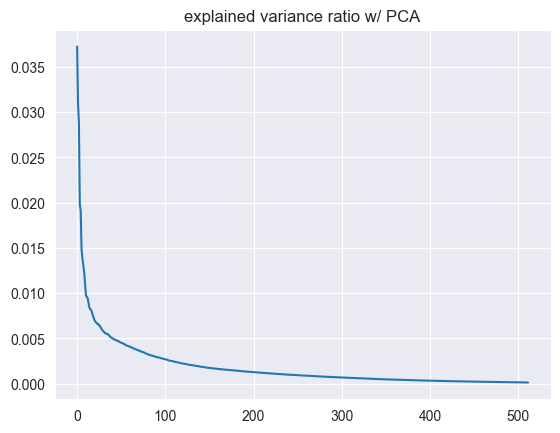

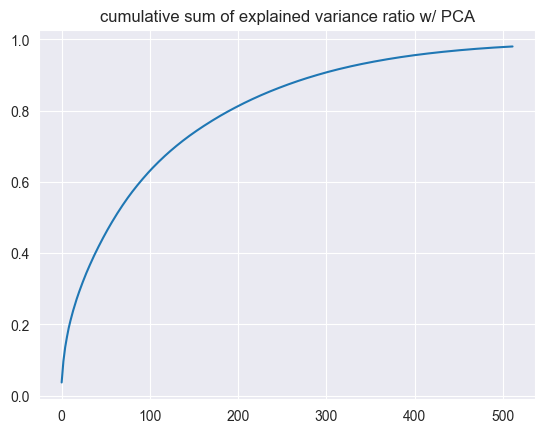

In [130]:
var_ratio = PCA_reducer.explained_variance_ratio_
plt.plot(var_ratio)
plt.title("explained variance ratio w/ PCA")
plt.show()
plt.plot(np.cumsum(var_ratio))
plt.title("cumulative sum of explained variance ratio w/ PCA")
plt.show()

In [131]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [132]:
label_encoder = LabelEncoder()
df['sector_encoded'] = label_encoder.fit_transform(df['industry'])
num_classes = len(df['industry'].unique())

C:\Users\matth\AppData\Local\Temp\ipykernel_27340\3309689667.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sector_encoded'] = label_encoder.fit_transform(df['industry'])


In [133]:
X = df[embedding_cols].values
# X = pca_embeddings
y = df['sector_encoded'].values

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [135]:
class EmbeddingDataset(Dataset):
    def __init__(self, features, labels, num_classes):
        self.features = features
        self.labels = F.one_hot(labels, num_classes).float()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

define model

In [136]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

set the model hyperparameters

In [137]:
input_size = X.shape[-1]
hidden_size = 256  # can be tuned
num_epochs = 20
learning_rate = 0.0001
batch_size = 256
device = torch.device("cpu") # change to cuda

In [138]:
train_dataset = EmbeddingDataset(X_train, y_train, num_classes=num_classes)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = EmbeddingDataset(X_test, y_test, num_classes=num_classes)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train the model

In [139]:
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features.to(device))
            loss = criterion(outputs, labels.to(device))
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    return avg_loss

Epoch [20/20], Training Loss: 224.9522, Validation Loss: 339.6650: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


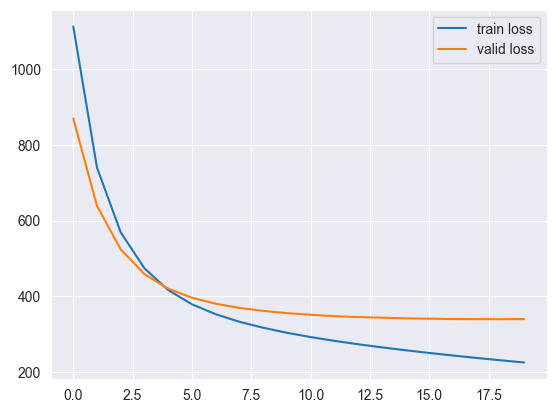

In [140]:
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
t_losses = []
v_losses = []
for epoch in (progress_bar := tqdm(range(num_epochs))):
    total_train_loss = 0
    for i, (features, labels) in enumerate(train_loader):
        outputs = model(features.to(device))
        loss = criterion(outputs, labels.to(device))
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss/len(train_loader)

    validation_loss = evaluate(model, test_loader, criterion)
    t_losses.append(avg_train_loss)
    v_losses.append(validation_loss)
    progress_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

plt.plot(t_losses)
plt.plot(v_losses)
plt.legend(['train loss', 'valid loss'])
plt.show()

In [141]:
def get_all_predictions(model, loader):
    model.eval()
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

    _, all_labels = torch.max(all_labels, 1)

    return all_preds, all_labels

In [142]:
predictions, true_labels = get_all_predictions(model, test_loader)

In [144]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
classes = label_encoder.classes_
unique_labels = np.unique(y_test)  # Unique labels in y_test

# Get the target names for the unique labels only
target_names = [classes[label] for label in unique_labels]

# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(predictions, true_labels, labels=unique_labels, average=None)

# Generate the classification report for the actual labels in y_test
report = classification_report(predictions, true_labels, labels=unique_labels, target_names=target_names)
print(report)

                                                precision    recall  f1-score   support

                          Advertising Agencies       0.55      0.58      0.57        53
                           Aerospace & Defense       0.74      0.61      0.67        66
                           Agricultural Inputs       0.71      0.79      0.75        38
                                      Airlines       0.89      0.89      0.89        19
                       Airports & Air Services       0.67      0.55      0.60        11
                                      Aluminum       0.63      1.00      0.77        12
                         Apparel Manufacturing       0.71      0.71      0.71        49
                                Apparel Retail       0.55      0.60      0.57        20
                              Asset Management       0.81      0.73      0.77       241
                      Auto & Truck Dealerships       0.79      0.70      0.75        27
                            Aut

C:\Users\matth\anaconda3\envs\cs4262\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matth\anaconda3\envs\cs4262\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matth\anaconda3\envs\cs4262\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matth\anaconda3\envs\cs4262\lib\si

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

cm = confusion_matrix(true_labels.numpy(), predictions.numpy())
accuracy = accuracy_score(true_labels.numpy(), predictions.numpy())
f1 = f1_score(true_labels.numpy(), predictions.numpy(), average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Pretty good, I guess?